# Imports

In [1]:
import sys
sys.path.append('..')

from src.utils import identify_missing_quarters, preprocess_text, extract_ngrams, sentiment_polarity
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from textblob import TextBlob

# Get the Data

In [2]:
data_directory = '../data/raw/'
transcript_files = glob.glob(os.path.join(data_directory, '*_transcripts.json'))

all_transcripts = []

# read all the files in the directory
for file in transcript_files:
    transcript_df = pd.read_json(file)
    all_transcripts.append(transcript_df)
# combine into one df
combined_transcripts_df = pd.concat(all_transcripts, ignore_index=True)
combined_transcripts_df.head()

,symbol,quarter,year,date,content
0,AAL,3,2023,2023-10-19 12:37:10,Operator: Thank you for standing by and welcom...
1,AAL,2,2023,2023-07-20 11:51:04,"Operator: Thank you for standing by, and welco..."
2,AAL,1,2023,2023-04-27 11:15:04,"Operator: Thank you for standing by, and welco..."
3,AAL,4,2022,2023-01-26 12:53:07,"Operator: Thank you for standing by, and welco..."
4,AAL,3,2022,2022-10-20 14:26:04,"Operator: Thank you for standing by, and welco..."


# Process Text

Doing basic pre-processing by using lower case, removing punction, tokenizing and lemmatizing and lastly removing stopwords.

In [3]:
combined_transcripts_df['cleaned_content'] = combined_transcripts_df['content'].apply(preprocess_text)

In [4]:
combined_transcripts_df.head()

,symbol,quarter,year,date,content,cleaned_content
0,AAL,3,2023,2023-10-19 12:37:10,Operator: Thank you for standing by and welcom...,operator thank standing welcome american airli...
1,AAL,2,2023,2023-07-20 11:51:04,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...
2,AAL,1,2023,2023-04-27 11:15:04,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...
3,AAL,4,2022,2023-01-26 12:53:07,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...
4,AAL,3,2022,2022-10-20 14:26:04,"Operator: Thank you for standing by, and welco...",operator thank standing welcome american airli...


Adding polarity and subjectivity columns, based on the sentiment. The sentiment column created using TextBlob is a tuple with the polarity and subjectivity scores. I kept the sentiment column in as a reference.

In [5]:
combined_transcripts_df['sentiment'] = combined_transcripts_df['cleaned_content'].apply(lambda text: TextBlob(text).sentiment)
combined_transcripts_df['polarity'] = combined_transcripts_df['sentiment'].apply(lambda x: x.polarity)
combined_transcripts_df['subjectivity'] = combined_transcripts_df['sentiment'].apply(lambda x: x.subjectivity)

In [6]:
combined_transcripts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   symbol           297 non-null    object        
 1   quarter          297 non-null    int64         
 2   year             297 non-null    int64         
 3   date             297 non-null    datetime64[ns]
 4   content          297 non-null    object        
 5   cleaned_content  297 non-null    object        
 6   sentiment        297 non-null    object        
 7   polarity         297 non-null    float64       
 8   subjectivity     297 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 21.0+ KB


# Visualizations

## Polarity

Polarity gauges the emotional direction of the text and ranges from -1 (negative emotions like anger or sadness) to +1 (positive emotions such as happiness or joy), with 0 representing neutrality. While evaulating earning call transcripts, it would be desirable to understand the emotional leaning of a particular earnings call to understand if there is any connection with the companies performance that could lead to an increase of the stock price. At the industry level, there could be value determing the direction of the industry based on the earnings calls.

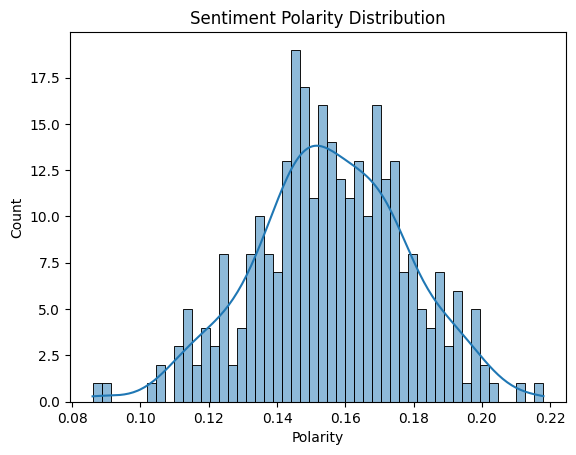

In [33]:
# looking at aggregate polarity distribution
sns.histplot(combined_transcripts_df['polarity'], bins = 50, kde = True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show()

The chart shown below shows the polarity of each quarter for the airline industry. The boxplot shows the range of values for the group and any outliers. The polarity scores seem to show neutrality to slightly positive. This can be expected given that we have done very light pre-processing of the text and have kept many of the filler words that are common from call to call, including the formalities. For the sake of this analysis, I will keep these in to create a basis to compare for future analyses. Reducing expected noise in future evaluations will help give a more accurate account of emotional direction of earnings calls. Keep in mind, however that calls tend to lean positive even given negative company performance due to management incentive to prevent anything negatively affecting the stock price. 

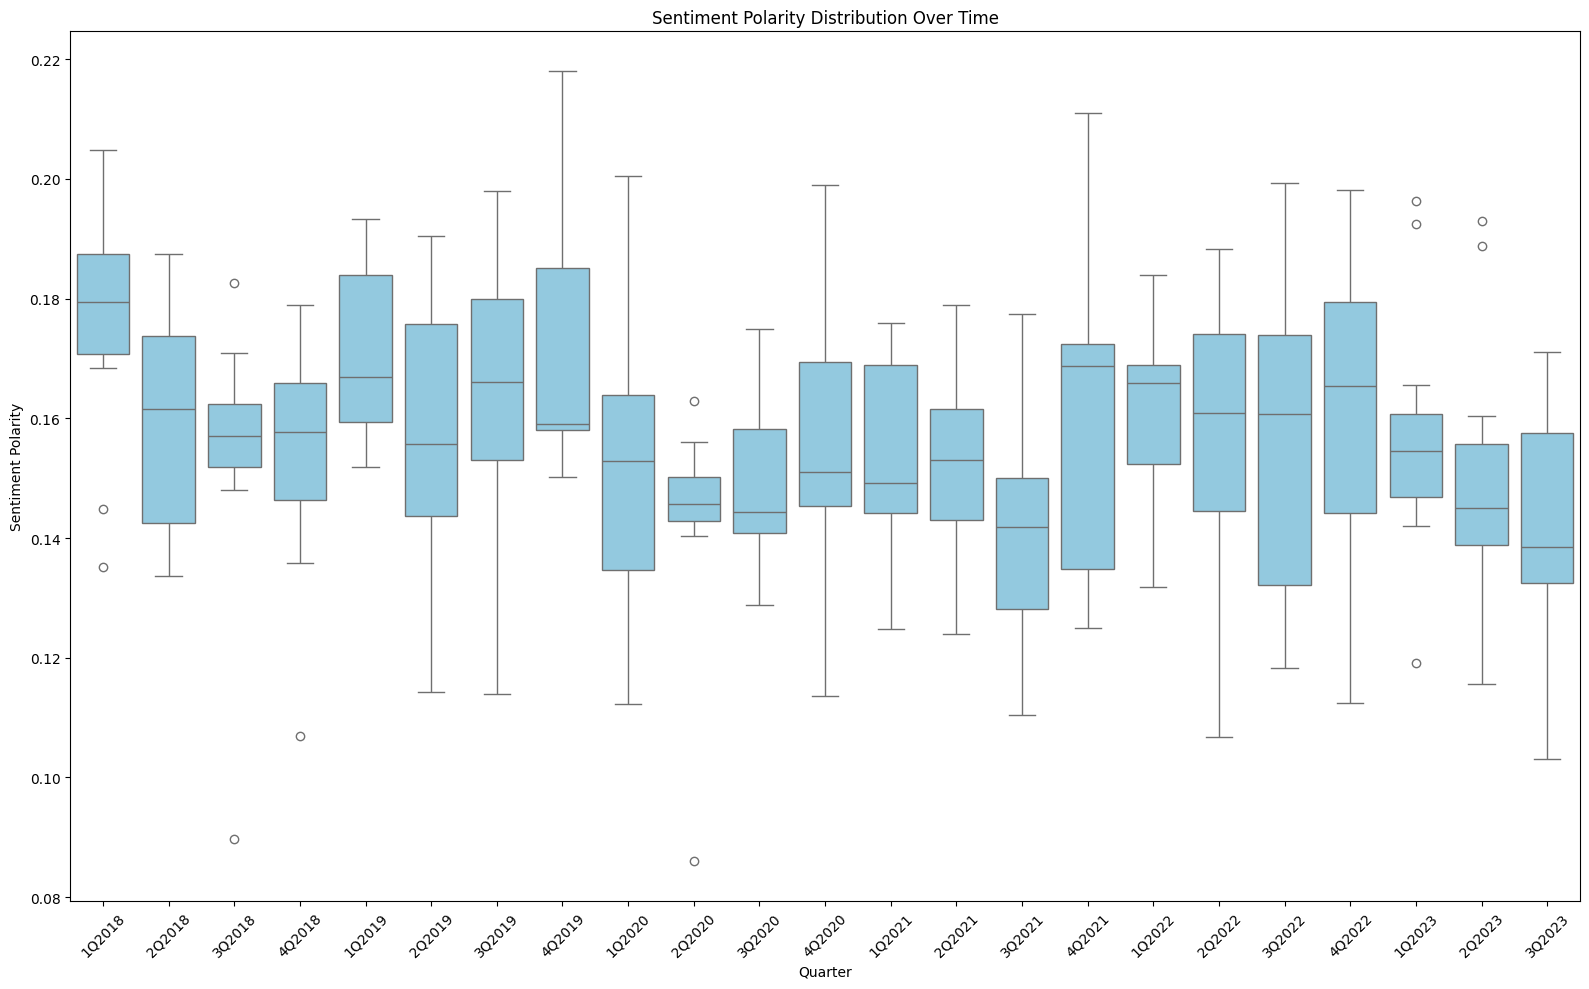

In [7]:
# Creating a quarter-year column
combined_transcripts_df['quarter_year'] = combined_transcripts_df['quarter'].astype(str) + 'Q' + combined_transcripts_df['year'].astype(str)
combined_transcripts_df.sort_values(by='date', ascending = True, inplace = True)

plt.figure(figsize=(16, 10))
sns.boxplot(data=combined_transcripts_df, x='quarter_year', y='polarity', color='skyblue')
plt.title('Sentiment Polarity Distribution Over Time')
plt.xlabel('Quarter')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here looking at polarity separately for each ticker. There are slight downtrends for several tickers, but since the axis is fairly granular, these changes are not large.

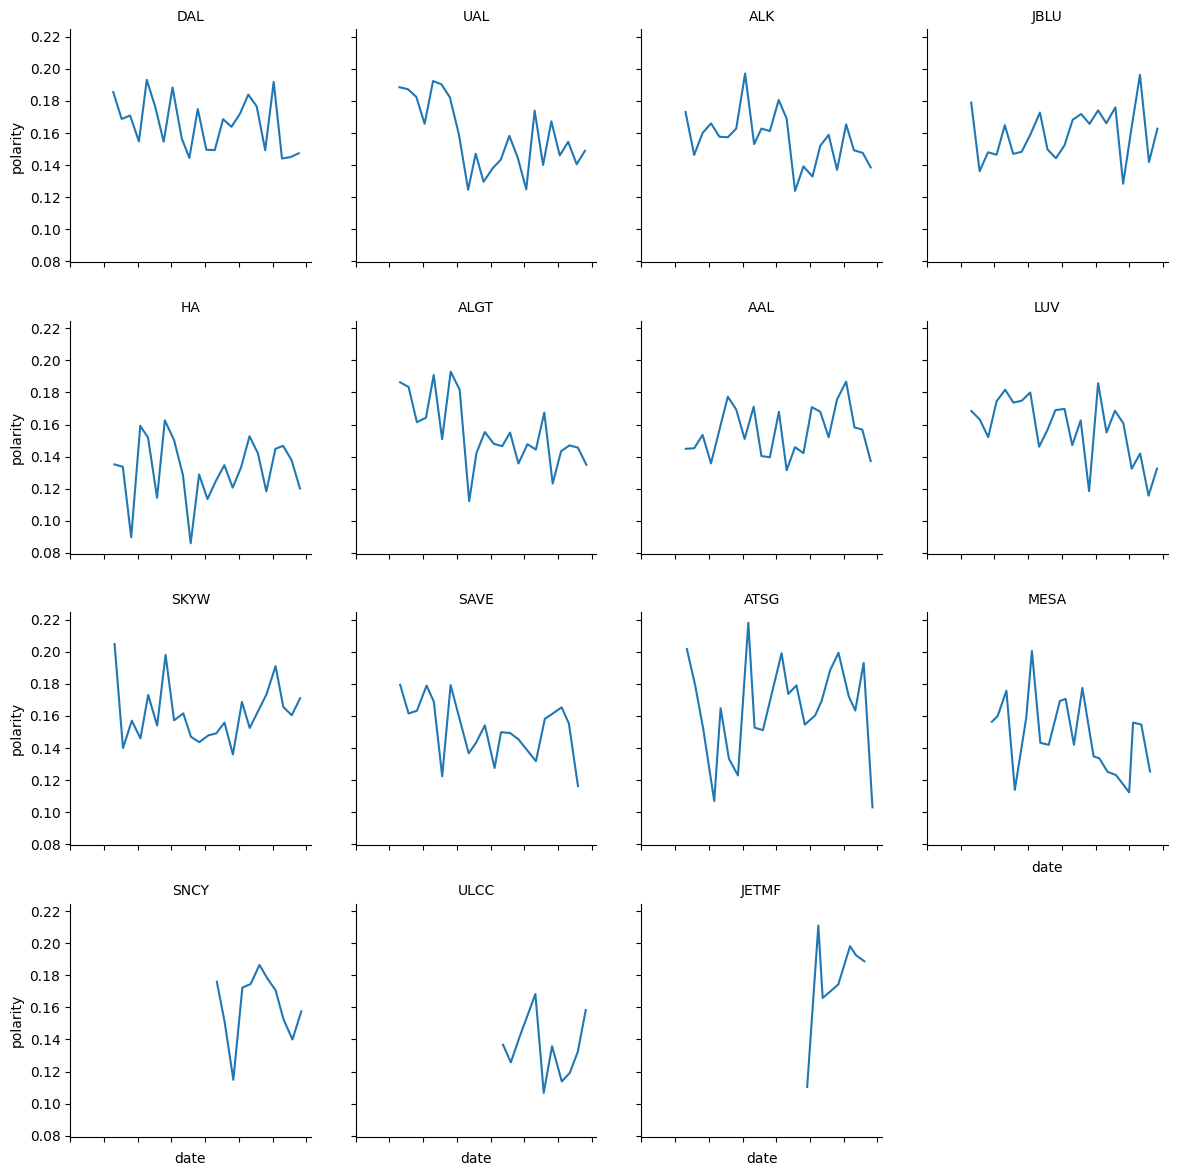

In [9]:
# creating a grid to look at each ticker
g = sns.FacetGrid(combined_transcripts_df, col="symbol", col_wrap=4, height=3, sharey=True)
g = g.map(plt.plot, "date", "polarity")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
plt.show()

The heatmap also shows a slight decrease over time across the group of tickers, though very slight.

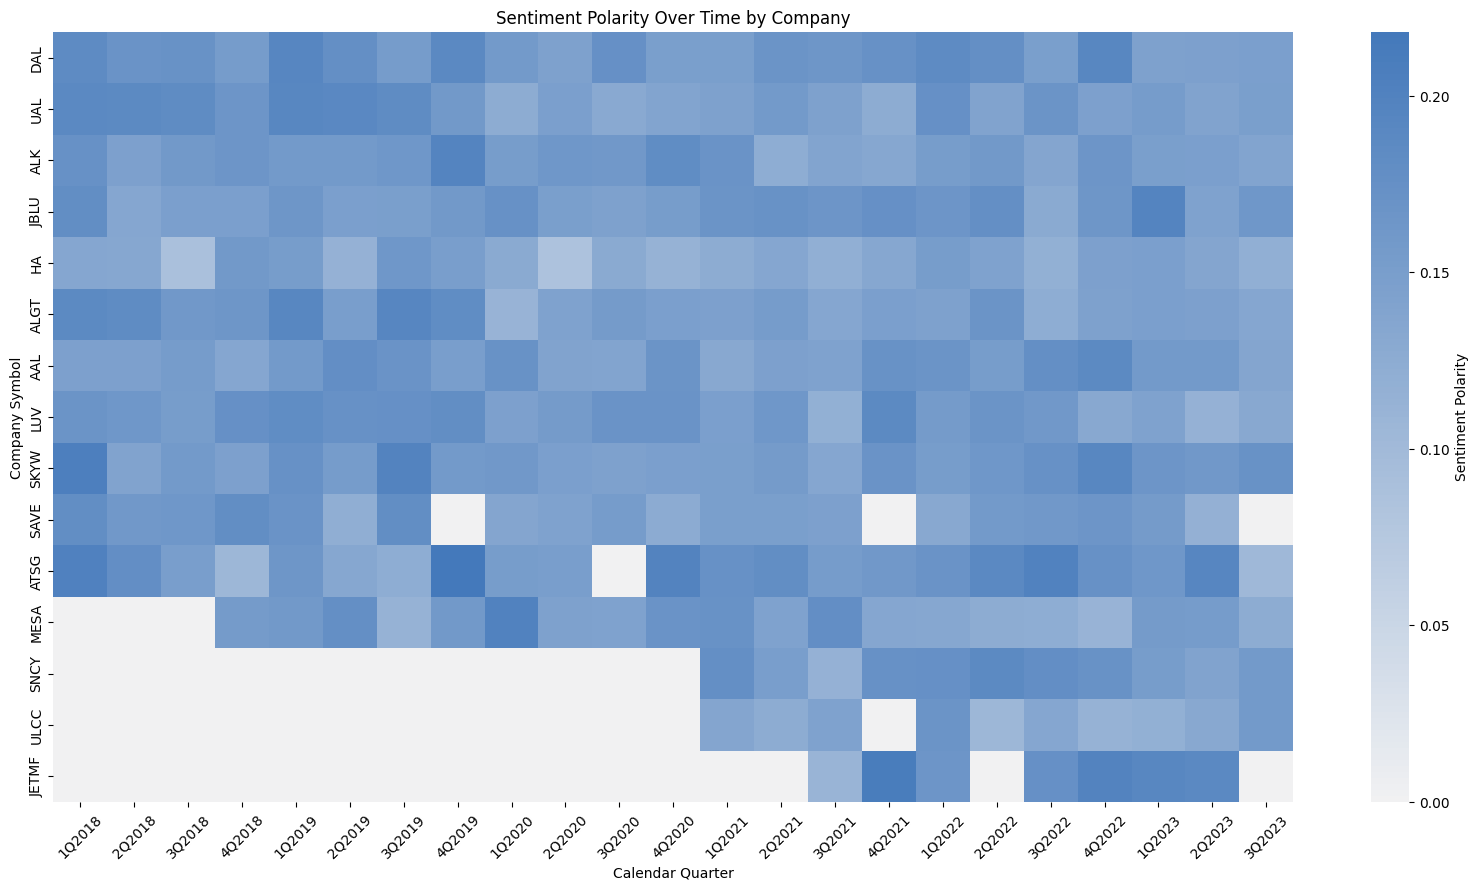

In [13]:
# Using sentiment polarity scores to create a heatmap over time
heatmap_data = combined_transcripts_df.pivot_table(index='symbol', columns='quarter_year', values='polarity', fill_value=0, sort = False)
cmap = sns.diverging_palette(240, 250, n=9, center="light", as_cmap=True)
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap=cmap, center=0, cbar_kws={'label': 'Sentiment Polarity', 'ticks': np.arange(0, max(heatmap_data.max().max(), 0.25), 0.05)})
plt.title('Sentiment Polarity Over Time by Ticker')
plt.xlabel('Quarter')
plt.ylabel('Ticker')
plt.xticks(rotation=45)
plt.show()

## Subjectivity

Subjectivity measures the amount of opinions (higher score) and facts (lower score) are in a text. Words such as "I believe", "the best", "in my opinion" can indicate possible subjectivity.

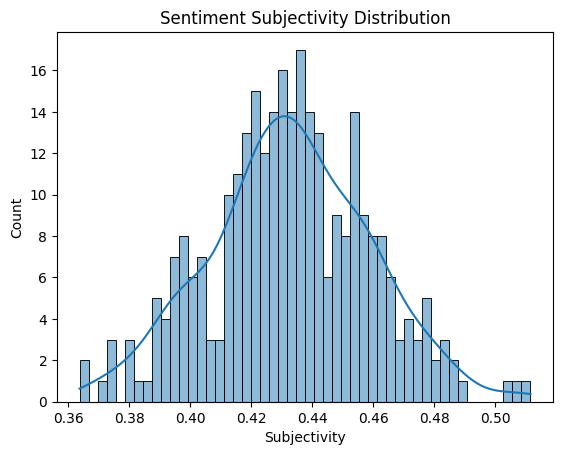

In [31]:
# looking at aggregate subjectivity distribution
sns.histplot(combined_transcripts_df['subjectivity'], bins = 50, kde = True)
plt.title('Sentiment Subjectivity Distribution')
plt.xlabel('Subjectivity')
plt.ylabel('Count')
plt.show()

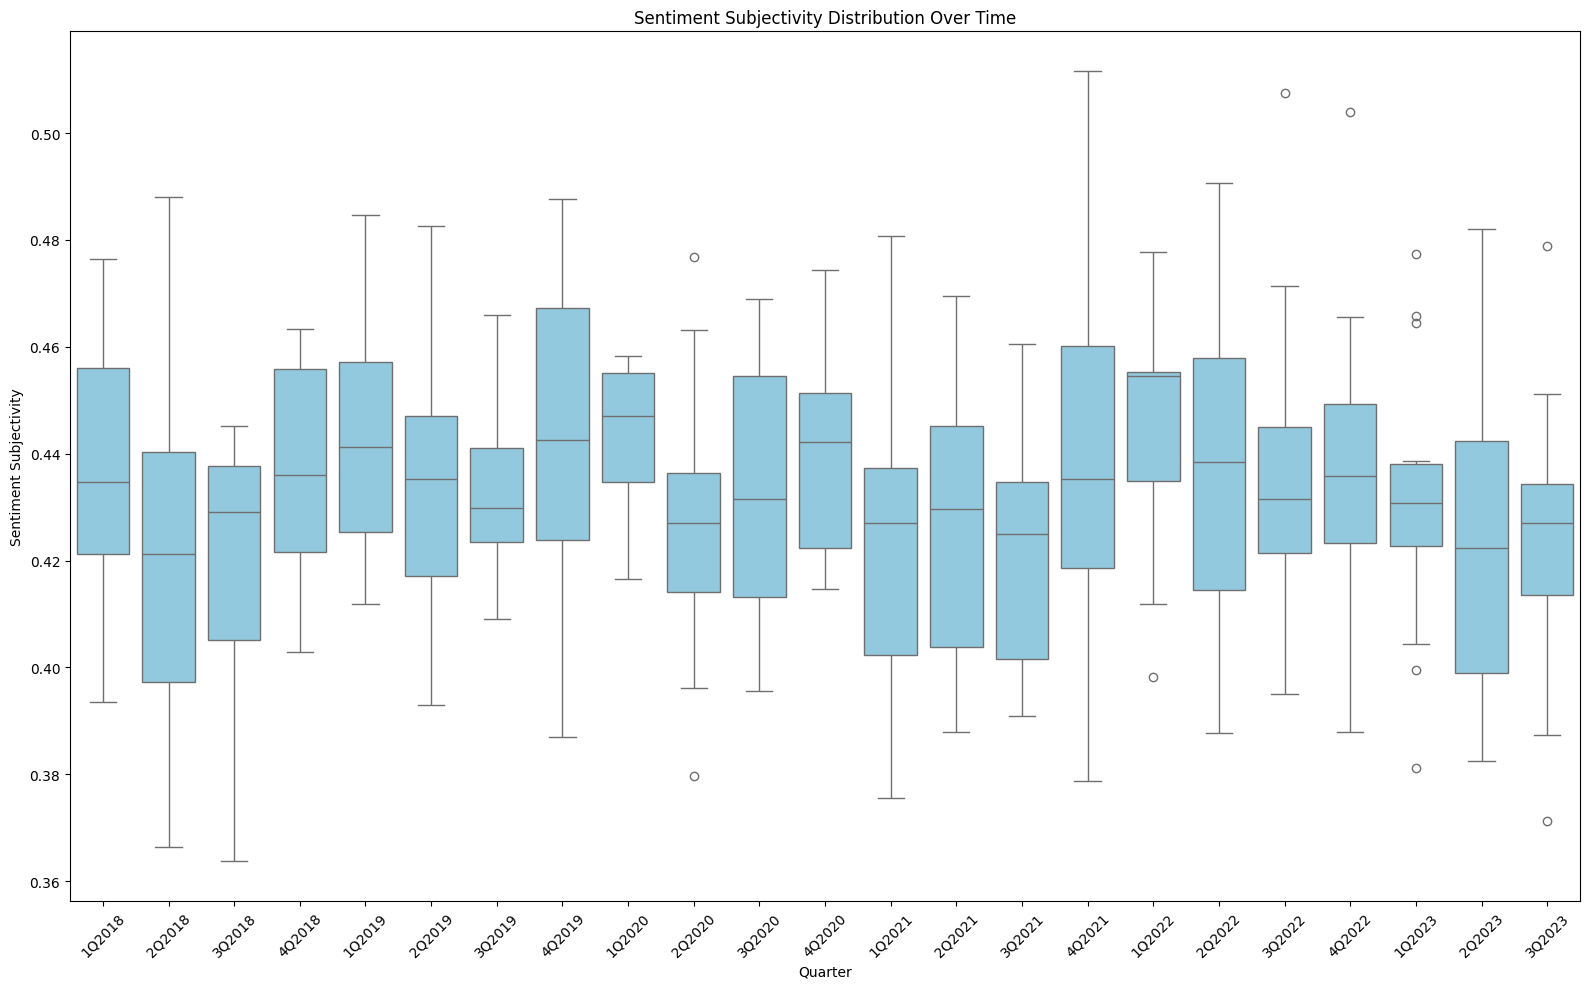

In [25]:
# We'll use the same charts for subjectivity that we did with polarity
plt.figure(figsize=(16, 10))
sns.boxplot(data=combined_transcripts_df, x='quarter_year', y='subjectivity', color='skyblue')
plt.title('Sentiment Subjectivity Distribution Over Time')
plt.xlabel('Quarter')
plt.ylabel('Sentiment Subjectivity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Similar to polarity, the grid below shows that subjectivity has a very slight downward tilt, with a few exceptions, though overall the changes are very minimal.

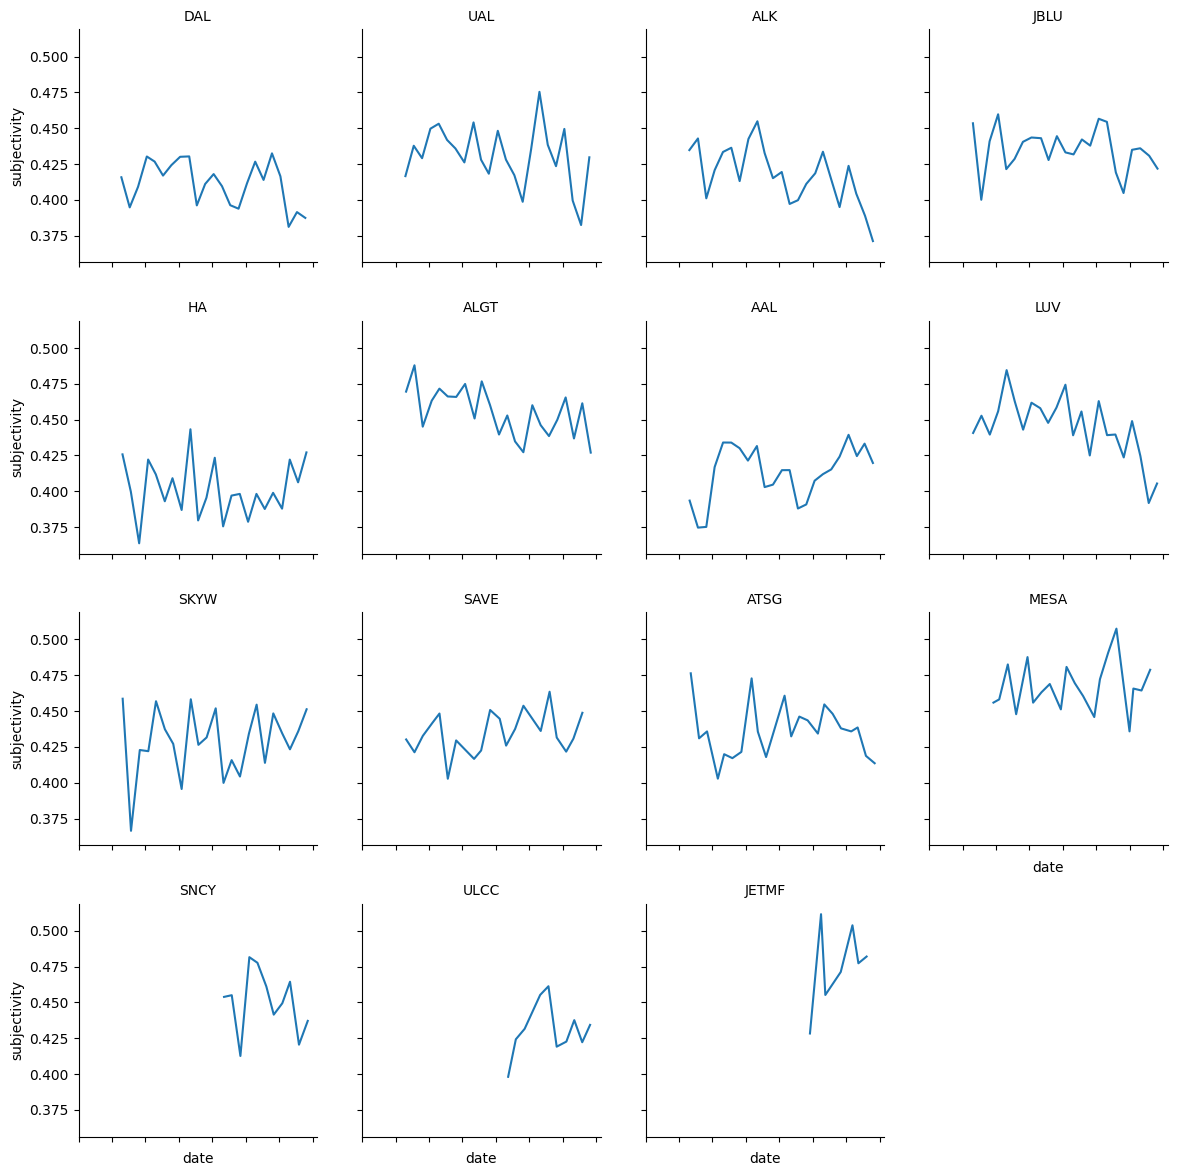

In [26]:
# here's the grid looking at each ticker
g = sns.FacetGrid(combined_transcripts_df, col="symbol", col_wrap=4, height=3, sharey=True)
g = g.map(plt.plot, "date", "subjectivity")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
plt.show()

The heatmap also shows the slight change over time, though a little more difficult to see compared to the polarity heatmap

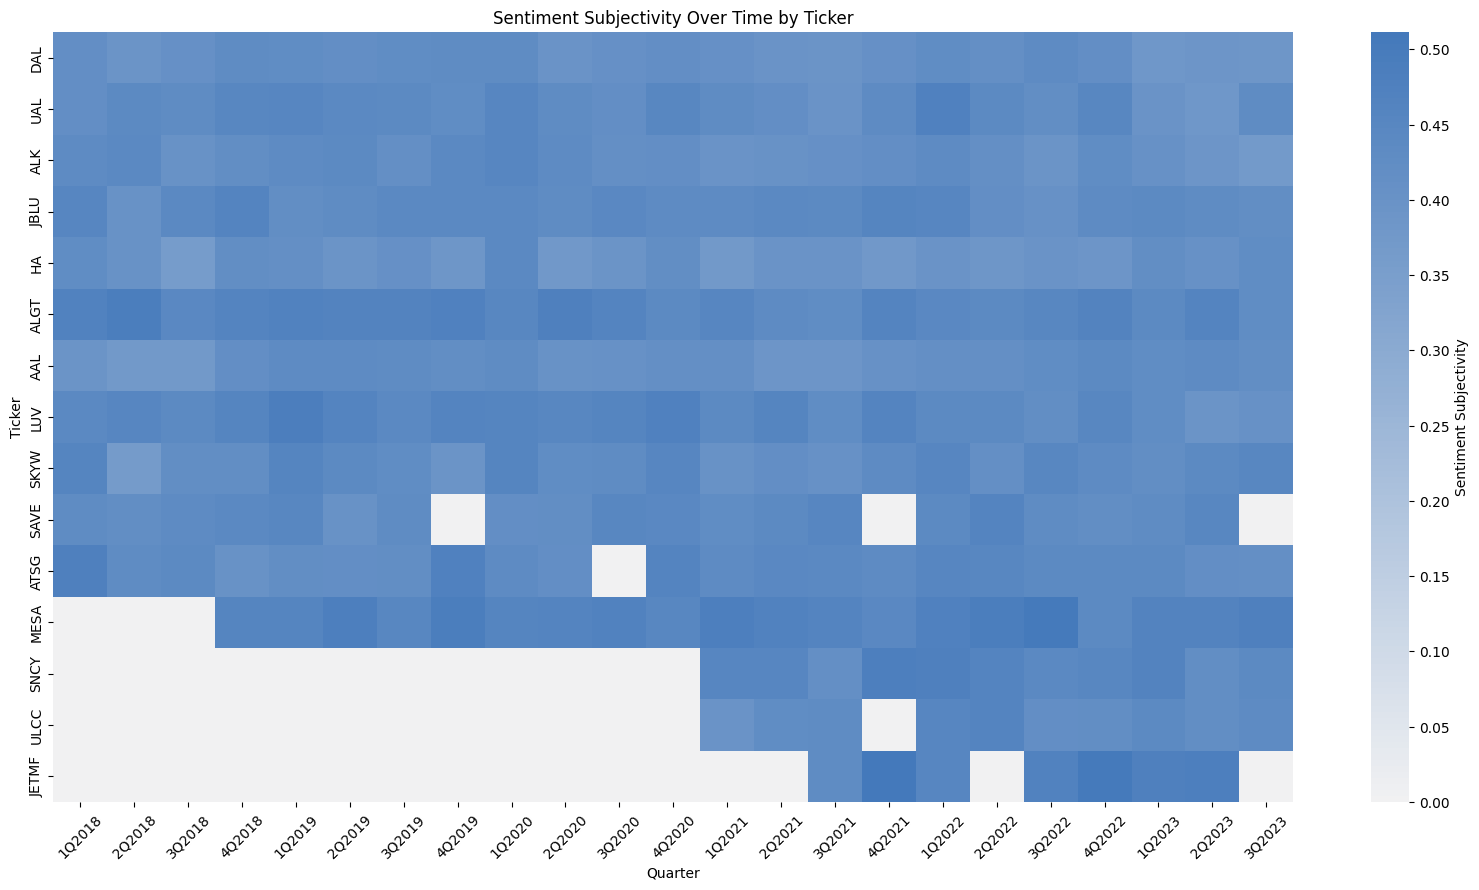

In [27]:
# Using sentiment subjectivity scores to create a heatmap over time
heatmap_data = combined_transcripts_df.pivot_table(index='symbol', columns='quarter_year', values='subjectivity', fill_value=0, sort = False)
cmap = sns.diverging_palette(240, 250, n=9, center="light", as_cmap=True)
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap=cmap, center=0, cbar_kws={'label': 'Sentiment Subjectivity', 'ticks': np.arange(0, max(heatmap_data.max().max(), 0.25), 0.05)})
plt.title('Sentiment Subjectivity Over Time by Ticker')
plt.xlabel('Quarter')
plt.ylabel('Ticker')
plt.xticks(rotation=45)
plt.show()